In [2]:
from contextlib import nullcontext

import h5py
import numpy as np
from PIL import Image
import numpy as np
from flatbuffers.packer import float64
from tensorflow.python.util.numpy_compat import np_array
#from CNN import X_train

Gives the bbox and label for n-th box

In [3]:
f = h5py.File("data/train_digitStruct.mat", "r")
bbox_refs = f["digitStruct"]["bbox"]
names_refs = f["digitStruct"]["name"]

def read_attr(attr):
    """Read a bbox attribute (left/top/width/height/label)."""
    # If it's a single reference
    if len(attr) == 1:
        return attr[0][0]
    # If multiple references
    return np.array([a[0] for a in attr]).astype(float)

def read_string(ref):
    return "".join([chr(c[0]) for c in f[ref]])

def get_name(i):
    name_ref = names_refs[i-1][0]
    return read_string(name_ref)

def get_boxes(img_num):
    master_ref = bbox_refs[img_num-1][0]
    bbox_data_struct = f[master_ref]
    label_refs = bbox_data_struct["label"]
    num_of_digits = label_refs.shape[0]

    def get_field(field, digit_num):
        field_refs = bbox_data_struct[field]

        # if only 1 digit in img then refrence is to float
        if (field_refs.dtype == np.dtype("float64")):
            field_value = field_refs[0][0].astype("int16")
        else: # otherwise have to get the that the specific digit_num
            field_value = f[field_refs[digit_num][0]][0][0].astype("int16")

        return field_value

    img_data = []
    label_data = []
    filepath = 'data/train/' + get_name(img_num)
    width, height = Image.open(filepath).size
    max_length = max(width, height) #CNN input will be 1:1. We use larger side to scale bounding boxes, because resizing preserves original image aspect ratio and adds zero padding to archieve 1:1 scale.
    for i in range(num_of_digits):
        '''
        digit_dict = {
            "left": get_field("left", i)/max_length,
            "top": get_field("top", i)/max_length,
            "height": get_field("height", i)/max_length,
            "width": get_field("width", i)/max_length,
#            "label": get_field("label", i),
        }
        '''
        if height > width:
            x = (get_field("left", i) + (height - width) / 2)/ height
            y = get_field("top", i) / height
            box_height = get_field("height", i) / height
            box_width = get_field("width", i) / height
        else:
            x = get_field("left", i) / width
            y = (get_field("top", i) + (width - height) / 2) / width
            box_height = get_field("height", i) / width
            box_width = get_field("width", i) / width

        digit_arr = np.array([x, y, box_height, box_width], dtype='float64')

        img_data.append(digit_arr)
        label_data.append(get_field("label", i))

    '''
    digit_dict = {
            "left": 0,
            "top": 0,
            "height": 0,
            "width": 0,
#            "label": 0,
        }
    '''
    digit_arr = np.array([0,0,0,0], dtype='float64')
    while len(img_data) < 6:
        img_data.append(digit_arr)
        label_data.append(0)
    return img_data, label_data

max_digits = 0
'''
for i in range(1, len(names_refs) + 1):
    data =  get_boxes(i)
    if len(data) > max_digits:
        max_digits = len(data)
    if i % 100 == 0:
        print(i)
'''



bbox_num = 1
filename = get_name(bbox_num)
box_info, label_info = get_boxes(bbox_num)
print(filename, box_info, label_info)
width2, height2 = Image.open('data/train/1.png').size
print(width2, height2)


max_digits # oli 6


1.png [array([0.43434343, 0.33333333, 0.3030303 , 0.19191919]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])] [np.int16(5), 0, 0, 0, 0, 0]
741 350


0

X_train

In [4]:
from PIL import Image
import numpy as np
import tensorflow as tf
image = Image.open('data/train/1.png')
image_array = np.array(image)

list = []
names = []


for i in range(1,33403):
    name = str(i) + ".png"
    path = 'data/train/' + name
    image = Image.open(path)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize_with_pad(image, 128, 128)
    image_array = np.array(image) / 255 #shape(height,width,3) - 3 is RGB.
    list.append(image_array)
    #names.append(name)
X_train = np.array(list)
# print(npArray.shape)
np.save("data/X_train.npy", X_train)
#X_train[0][0]

#names


In [5]:
list = None

In [7]:

#Array of bounding boxes for each image
#TODO maybe each array element should have a value for image name.
bbox_array = []
labels_array = []
for i in range(1, 33403):
#    filename = get_name(i)
    bboxes, labels = get_boxes(i)
    bbox_array.append(bboxes)
    labels_array.append(labels)
#    info_array = []
#    for info in box_info:
#        arr = [info["left"], info["top"], info["height"], info["width"], info["label"]]
#        info_array.append(arr)
#    bbox_array.append(np.array(info_array))
y_train = np.array(bbox_array)
np.save("data/y_train.npy", y_train)
#y_train[0][0]




In [8]:
labels_train = np.array(labels_array)
np.save("data/labels_train.npy", labels_train)
bbox_array = None
label_info = None
bbox_refs = None
f = None
names_refs = None

In [68]:
image = Image.open('data/train/1.png')
b = []
a = np.array(image)
b.append(a)
c = np.array(b, dtype='object')
c.shape

(1, 350, 741, 3)

In [ ]:
image = Image.open(path)#.convert('L')
image = tf.image.resize_with_pad(image, 224, 224)
image_array = np.array(image) / 255

[41.84615385 48.         36.92307692 19.69230769]


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

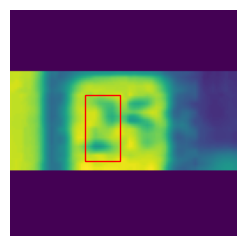

In [123]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(10, 10))
ax = plt.subplot(3, 3, 3)
image = X_train[2] *255
bbox = y_train[2][0] * 128
plt.imshow(image.astype("uint8"))
print(bbox)
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[3], bbox[2], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
#plt.title(class_names[labels[i]])
plt.axis("off")

(np.float64(-0.5), np.float64(740.5), np.float64(349.5), np.float64(-0.5))

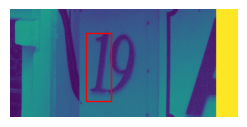

In [143]:
image = Image.open('data/train/1.png')
image = tf.image.rgb_to_grayscale(image)
image = np.array(image)

plt.figure(figsize=(10, 10))
ax = plt.subplot(3, 3, 3)
plt.imshow(image.astype("uint8"))
rect2 = patches.Rectangle((246, 77), 81, 219, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect2)
plt.axis("off")

In [72]:
image.shape

(350, 741, 3)

In [73]:
X_train[0].shape

(128, 128, 1)

In [74]:
bbox

array([42.49392713, 18.06782768, 51.38771769, 13.99190283])